In [ ]:
%pip install -r -requirements.txt

In [ ]:
import torch

import os
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день:
Будет дождь, если rainfall >=1

In [17]:
df = pd.read_csv('datasets/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Удалим столбцы

In [18]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [19]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [ ]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

Классы несбалансированы

In [21]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [22]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [23]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)

    # torch.nn.init.xavier_uniform_(self.fc1.weight)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [28]:
device = torch.device("cpu")

In [29]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)
epochs = range(1, 1001)

1. Обучение и оценка модели с различными learning rates

In [30]:
def train_and_evaluate(learning_rate):
    net = Net(4)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in epochs:
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

Optimal learning rate: 0.001


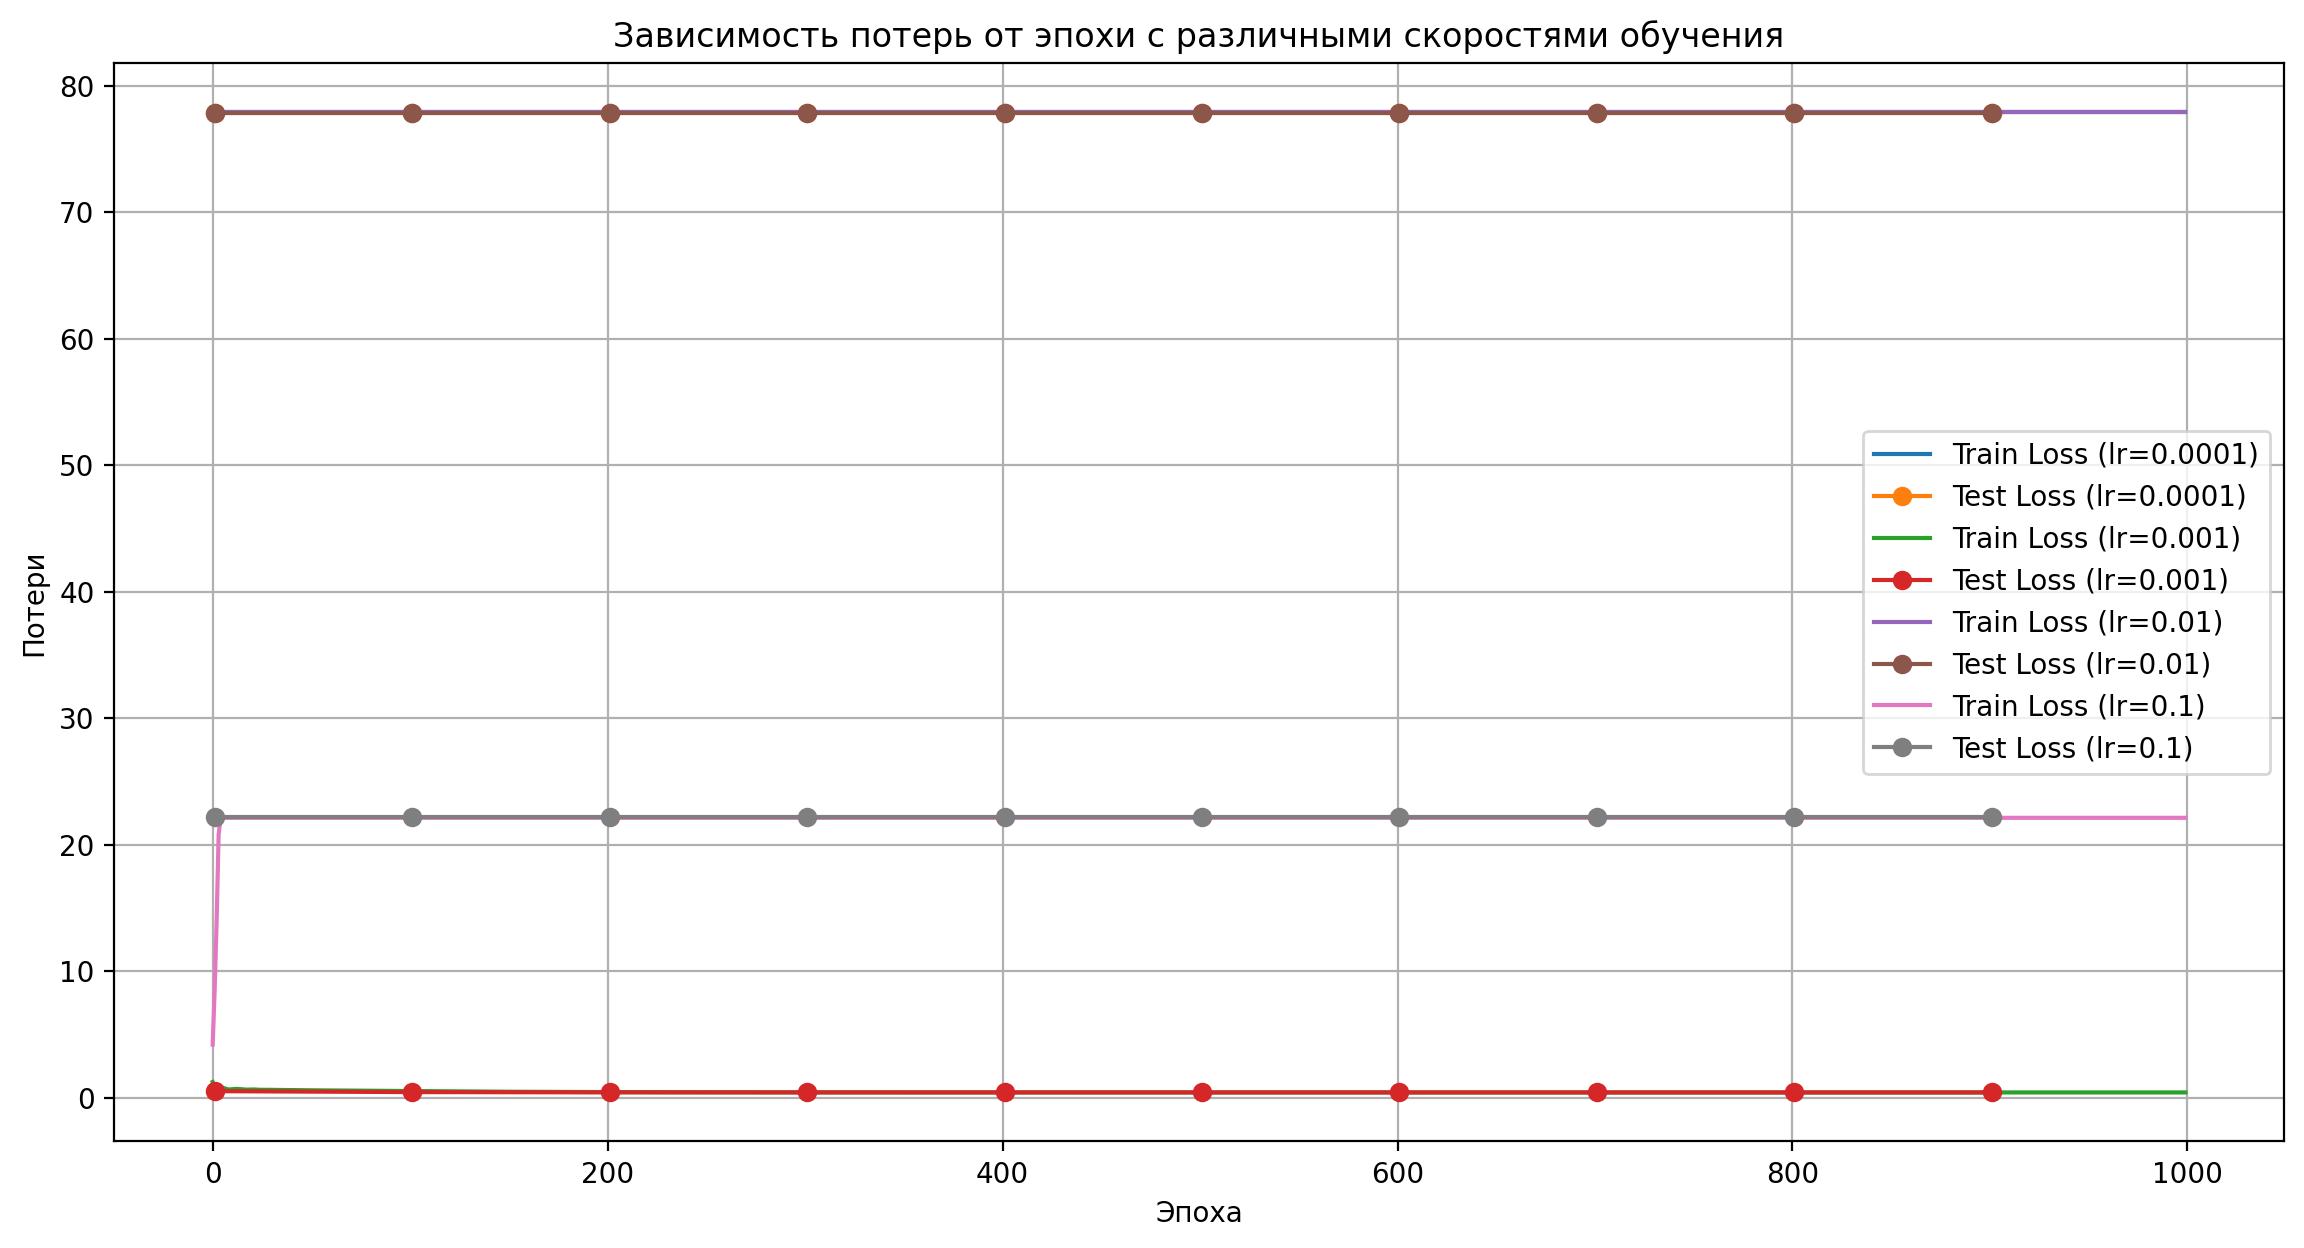

In [31]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
train_loss_dict = {}
test_loss_dict = {}
test_loss_summary = {}

for lr in learning_rates:
    train_losses, test_losses = train_and_evaluate(lr)
    train_loss_dict[lr] = train_losses
    test_loss_dict[lr] = test_losses
    test_loss_summary[lr] = test_losses[-1]

optimal_lr = min(test_loss_summary, key=test_loss_summary.get)
print(f'Optimal learning rate: {optimal_lr}')

epochs_plot = range(1, 1001, 100)

plt.figure(figsize=(14, 7))

for lr in learning_rates:
    plt.plot(train_loss_dict[lr], label=f'Train Loss (lr={lr})')
    plt.plot(epochs_plot, test_loss_dict[lr], label=f'Test Loss (lr={lr})', marker='o')

plt.title('Зависимость потерь от эпохи с различными скоростями обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

2. Примените нормализацию данных. Исследуйте скорость сходимости.

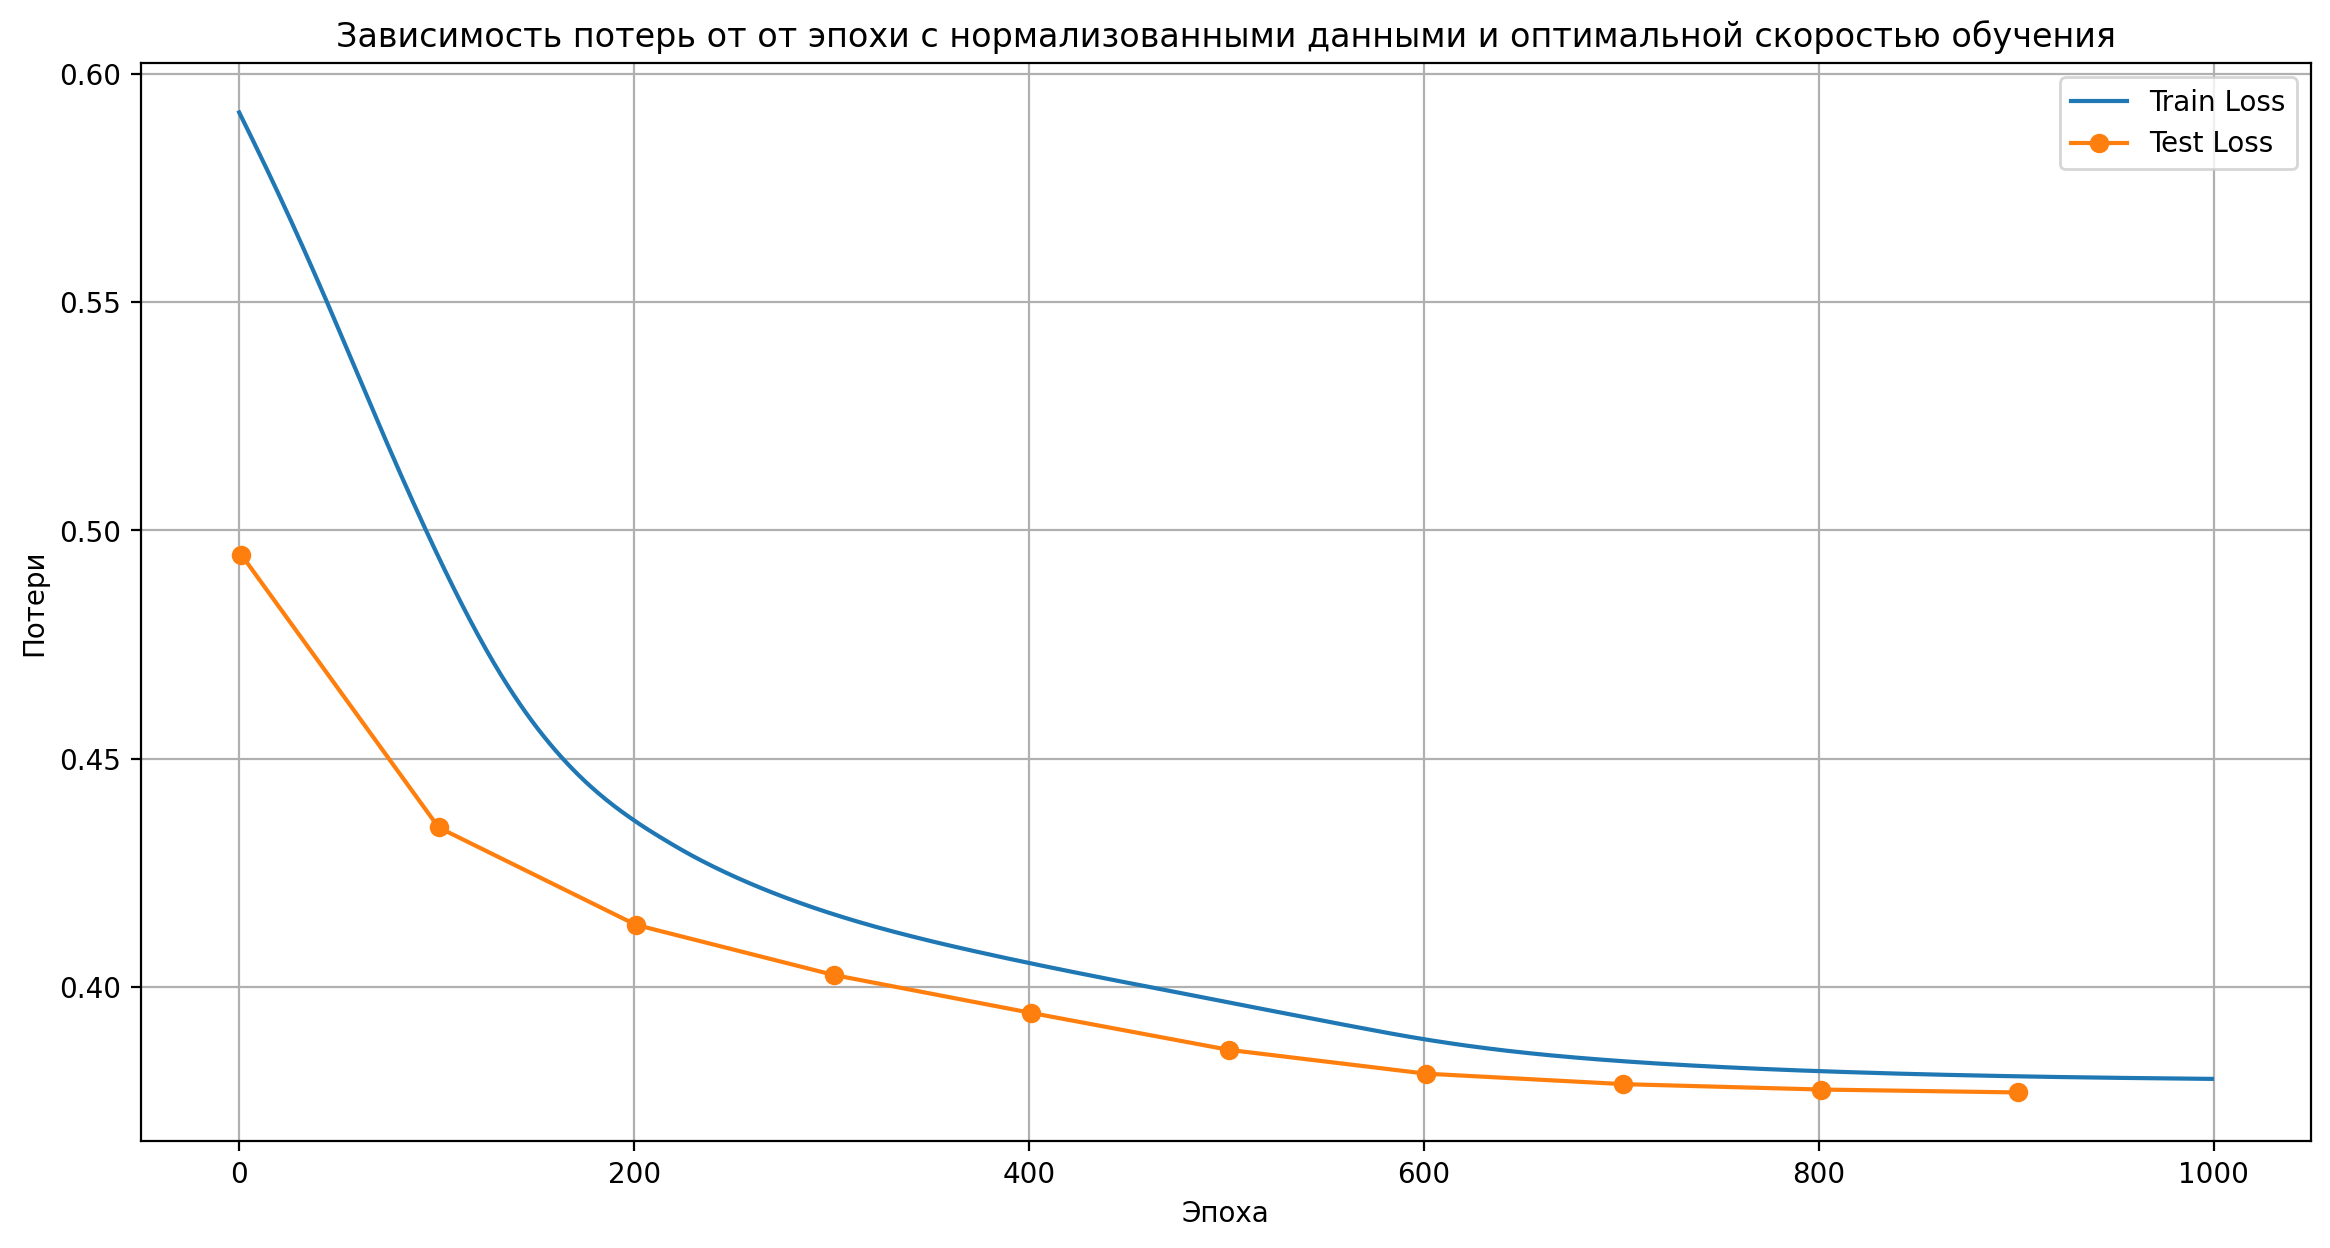

In [32]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

train_losses, test_losses = train_and_evaluate(optimal_lr)

plt.figure(figsize=(14, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(epochs_plot, test_losses, label='Test Loss', marker='o')

plt.title('Зависимость потерь от от эпохи с нормализованными данными и оптимальной скоростью обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
скрытого слоя, Удаления/добавления нейронов в каждом слое.

In [33]:
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size

        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', nn.ReLU())
            last_size = layer_size

        self.layers.add_module('output', nn.Linear(last_size, 1))

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [34]:

def train_and_evaluate(hidden_layers, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in epochs:
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

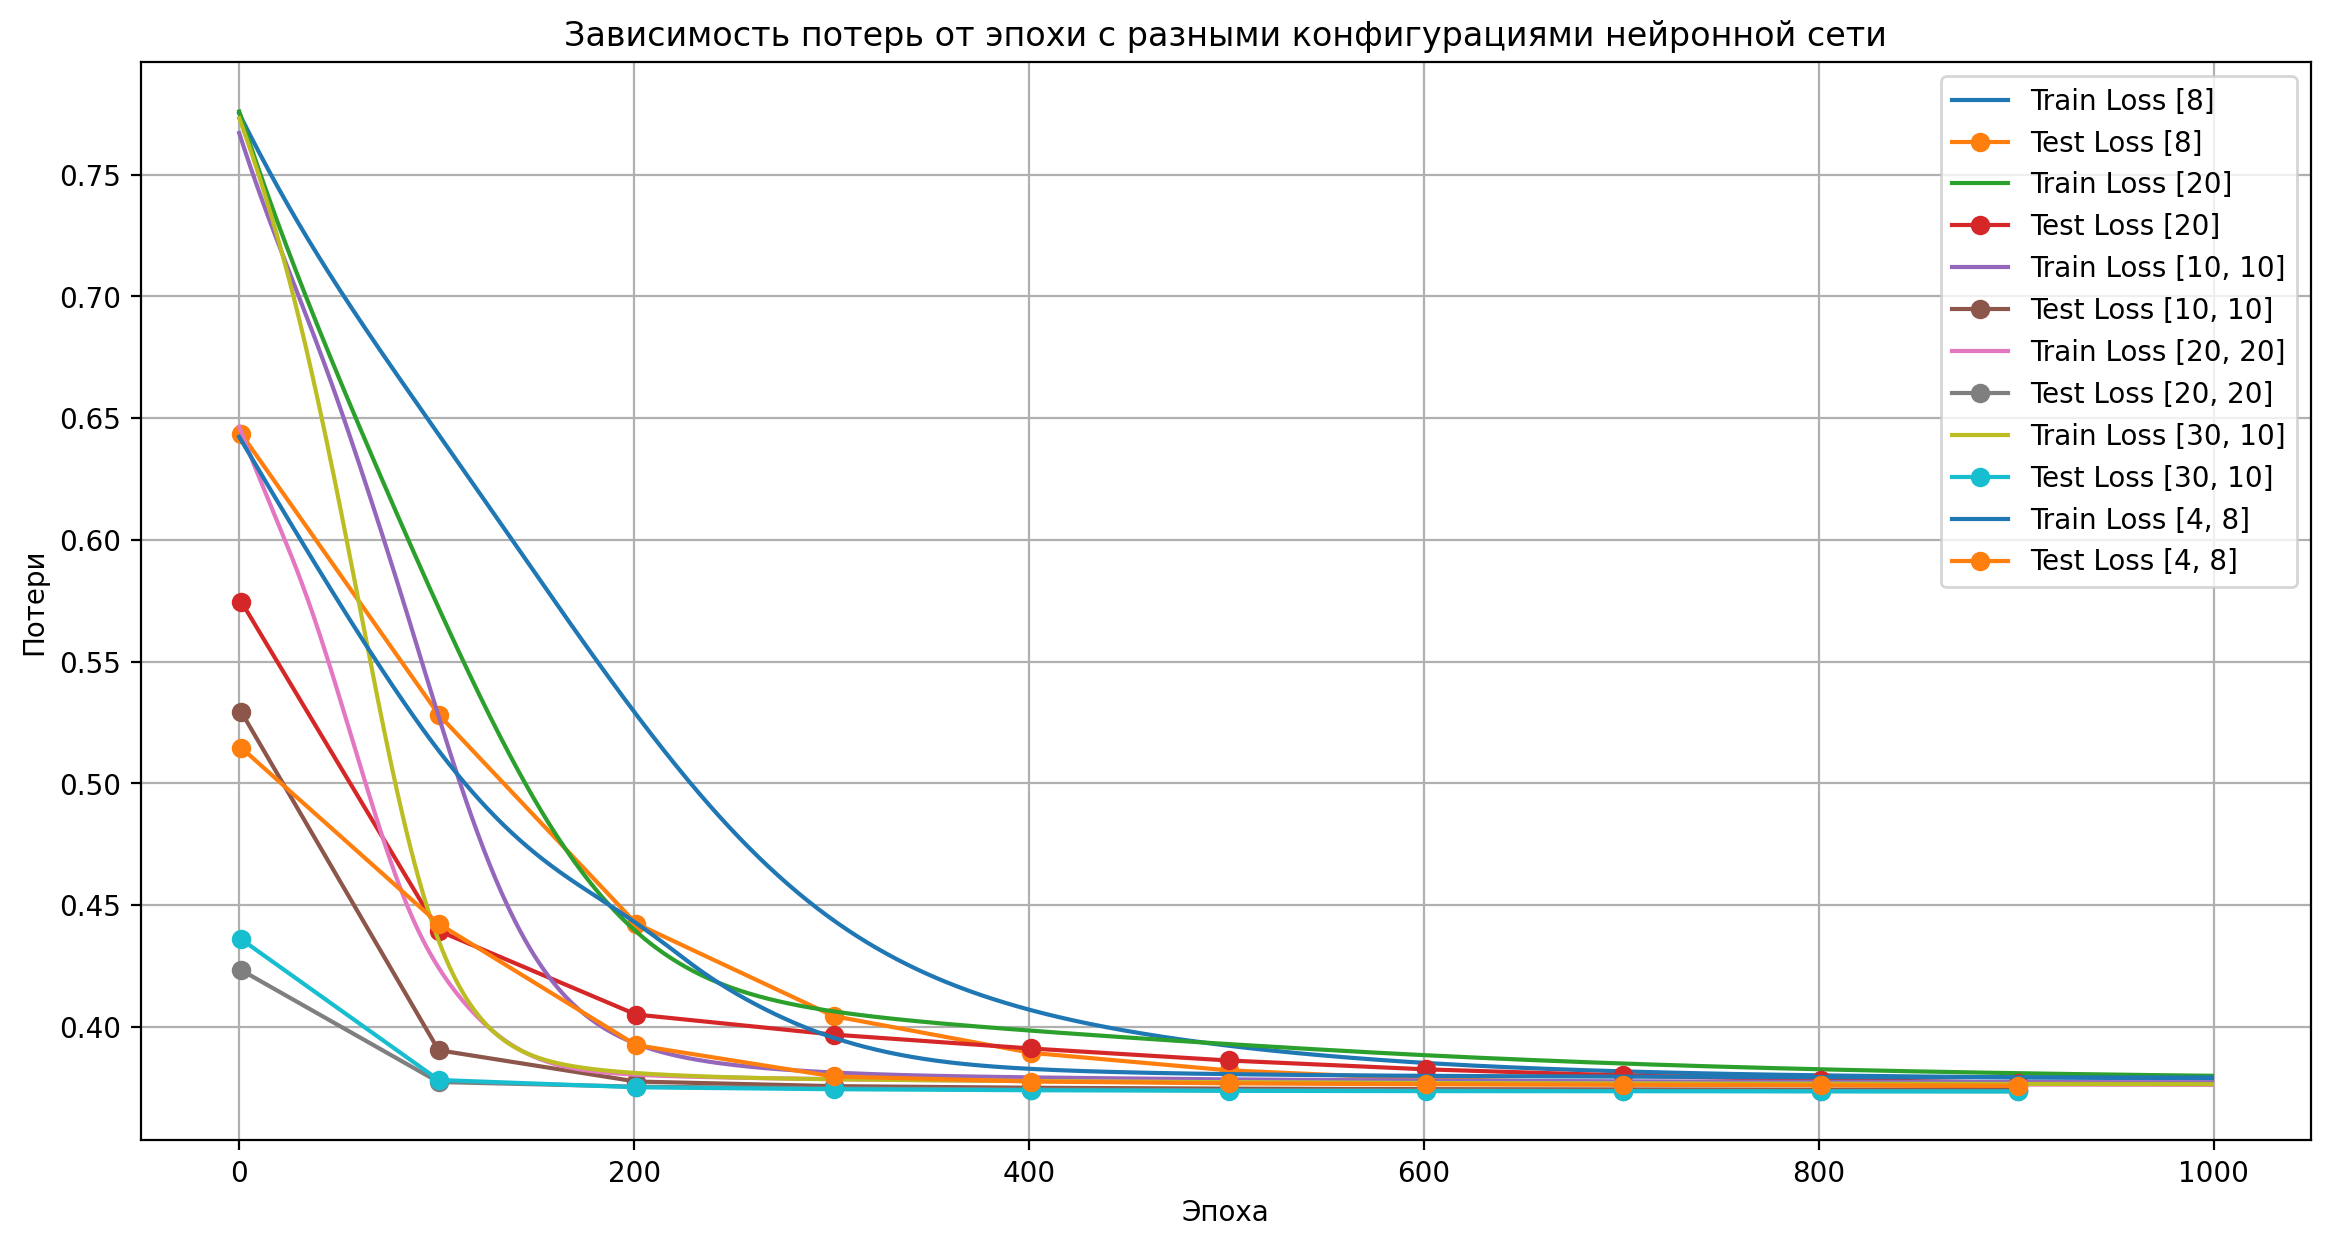

  Configuration  Потери валидации
0           [8]          0.375558
1          [20]          0.377058
2      [10, 10]          0.374088
3      [20, 20]          0.373545
4      [30, 10]          0.373469
5        [4, 8]          0.375900


In [35]:
configurations = [
    [8],                # Один скрытый слой с 8 нейронами
    [20],               # Один скрытый слой с 20 нейронами
    [10, 10],           # Два скрытых слоя с 10 нейронами
    [20, 20],           # Два скрытых слоя с 20 нейронами
    [30, 10],           # Один скрытый слой с 30 нейронами и один с 10
    [4, 8]              # Один скрытый слой с 4 нейронами и один с 8
]
results = {}

for config in configurations:
    train_losses, test_losses = train_and_evaluate(config)
    results[str(config)] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for config, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {config}')
    plt.plot(epochs_plot, data['test_loss'], label=f'Test Loss {config}', marker='o')

plt.title('Зависимость потерь от эпохи с разными конфигурациями нейронной сети')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Configuration': [k for k in results.keys()],
    'Потери валидации': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.

In [36]:
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size

        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size

        self.layers.add_module('output', nn.Linear(last_size, 1))

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [37]:

def train_and_evaluate(hidden_layers, activation_fn, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in epochs:
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

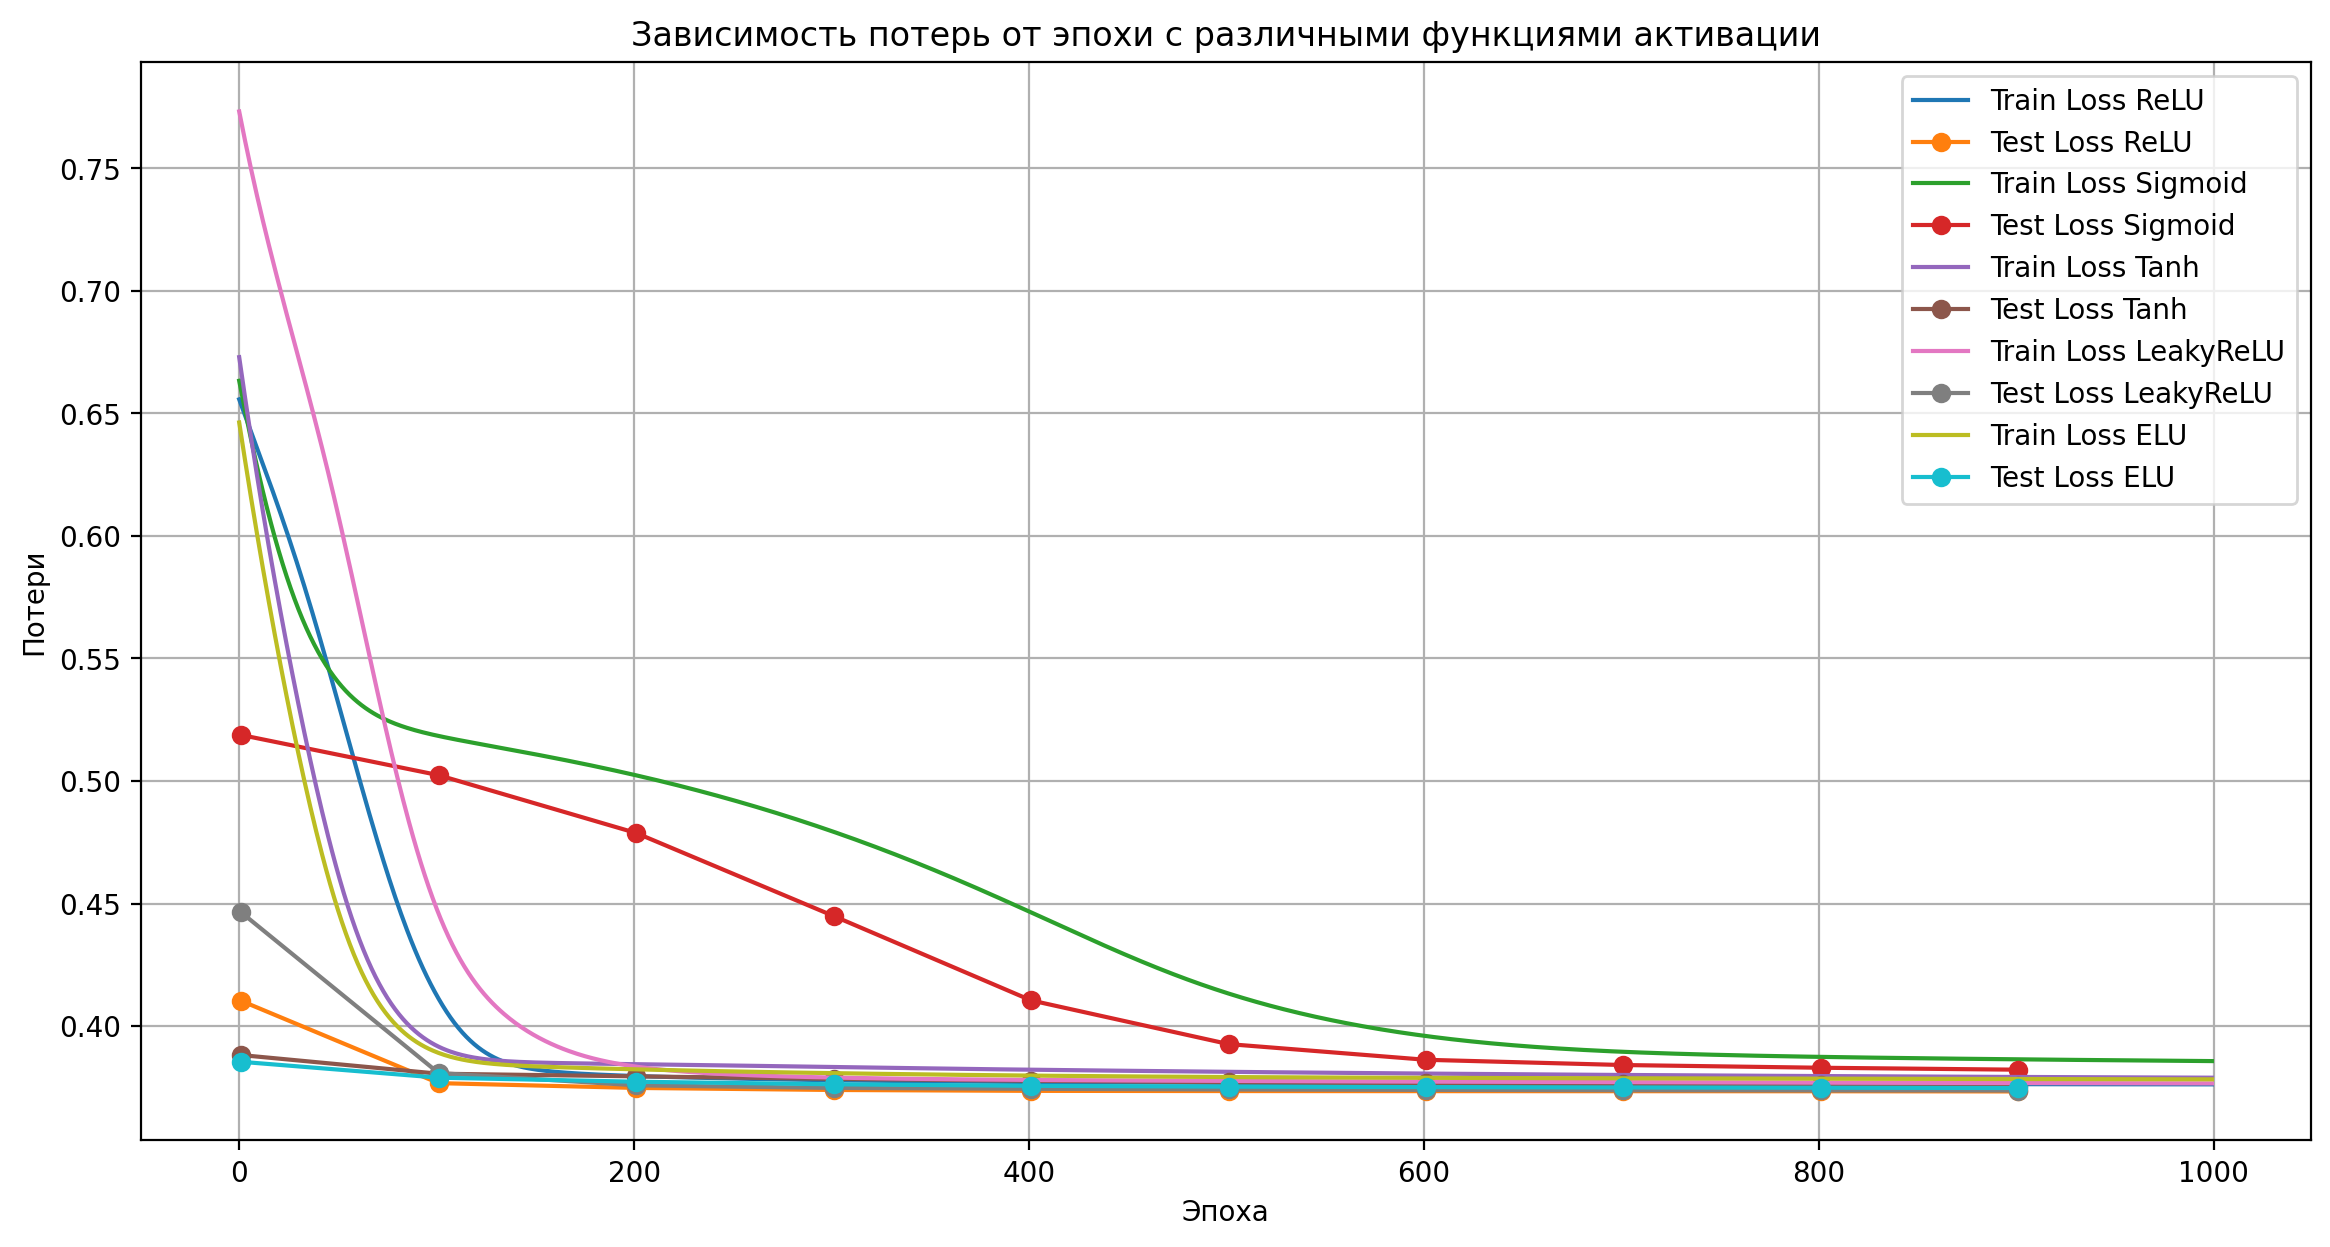

  Activation Function  Потери валидации
0                ReLU          0.373340
1             Sigmoid          0.382215
2                Tanh          0.375660
3           LeakyReLU          0.373720
4                 ELU          0.374742


In [38]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
}

results = {}

for name, activation_fn in activation_functions.items():
    hidden_layers = [20, 20]
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(epochs_plot, data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Зависимость потерь от эпохи с различными функциями активации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Activation Function': [k for k in results.keys()],
    'Потери валидации': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.

In [39]:
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size

        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size

        self.layers.add_module('output', nn.Linear(last_size, 1))

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [40]:
def train_and_evaluate(hidden_layers, activation_fn, optimizer_class, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optimizer_class(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in epochs:
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

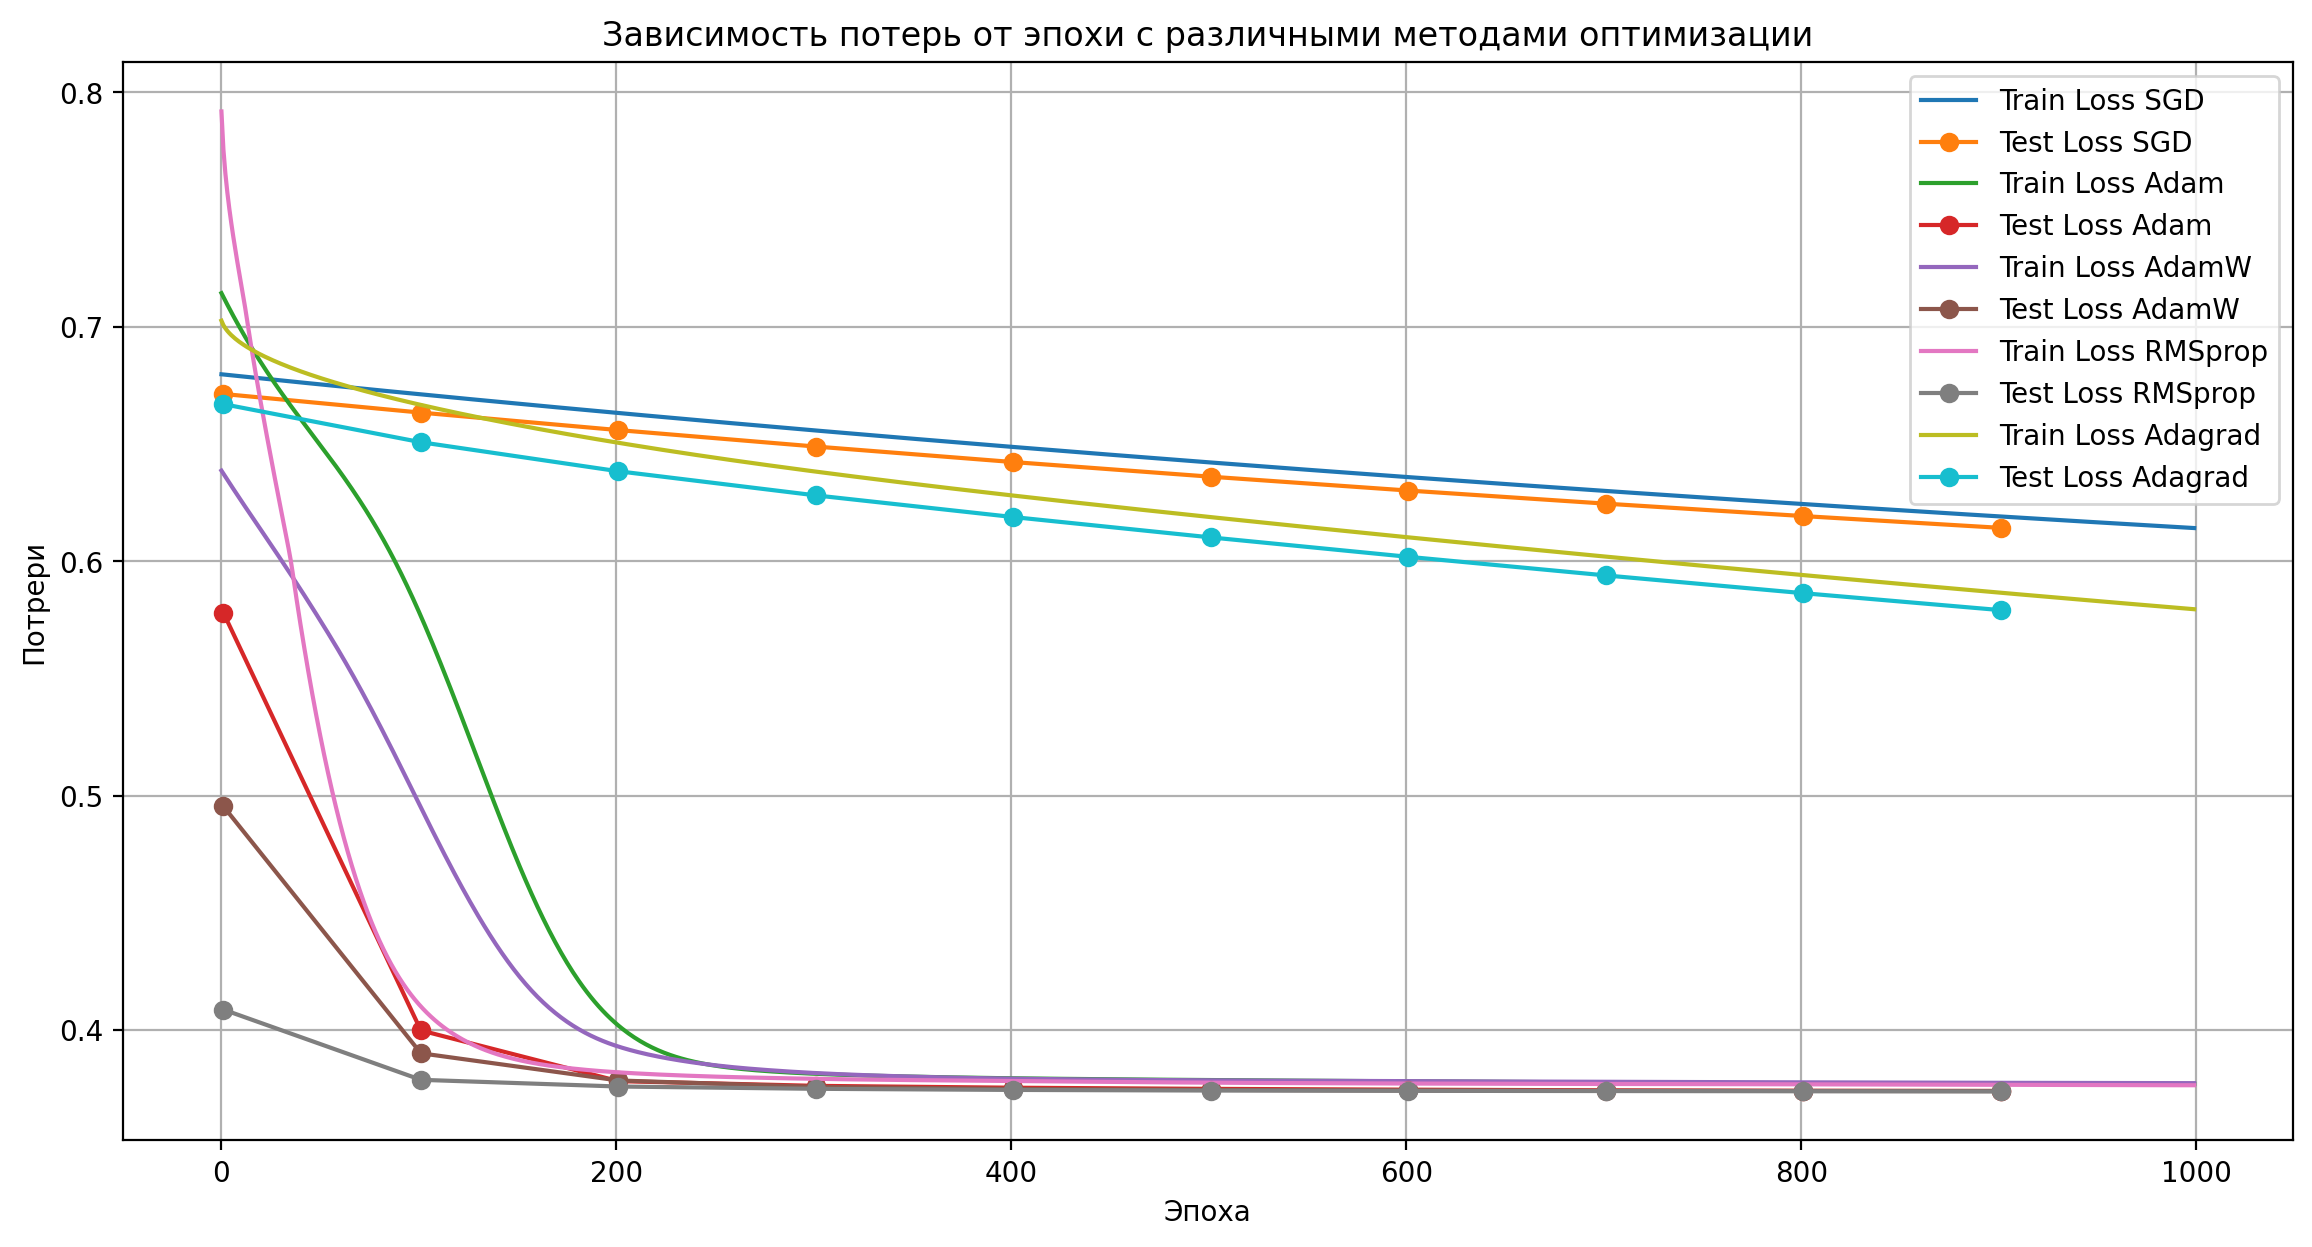

  Optimizer  Потери валидации
0       SGD          0.614257
1      Adam          0.374079
2     AdamW          0.374015
3   RMSprop          0.373855
4   Adagrad          0.579167


In [41]:
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
}

activation_fn = nn.LeakyReLU()
hidden_layers = [10, 10]

results = {}

for name, optimizer_class in optimizers.items():
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, optimizer_class)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(epochs_plot, data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Зависимость потерь от эпохи с различными методами оптимизации')
plt.xlabel('Эпоха')
plt.ylabel('Потрери')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Optimizer': [k for k in results.keys()],
    'Потери валидации': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [46]:
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, weight_init):
        super(CustomNet, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size

        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size

        self.layers.add_module('output', nn.Linear(last_size, 1))

        self.apply(weight_init)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [47]:

def train_and_evaluate(hidden_layers, activation_fn, weight_init, learning_rate=optimal_lr):
    net = CustomNet(4, hidden_layers, activation_fn, weight_init)
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in epochs:
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

In [48]:
def init_weights_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)

def init_weights_random(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def init_weights_Kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

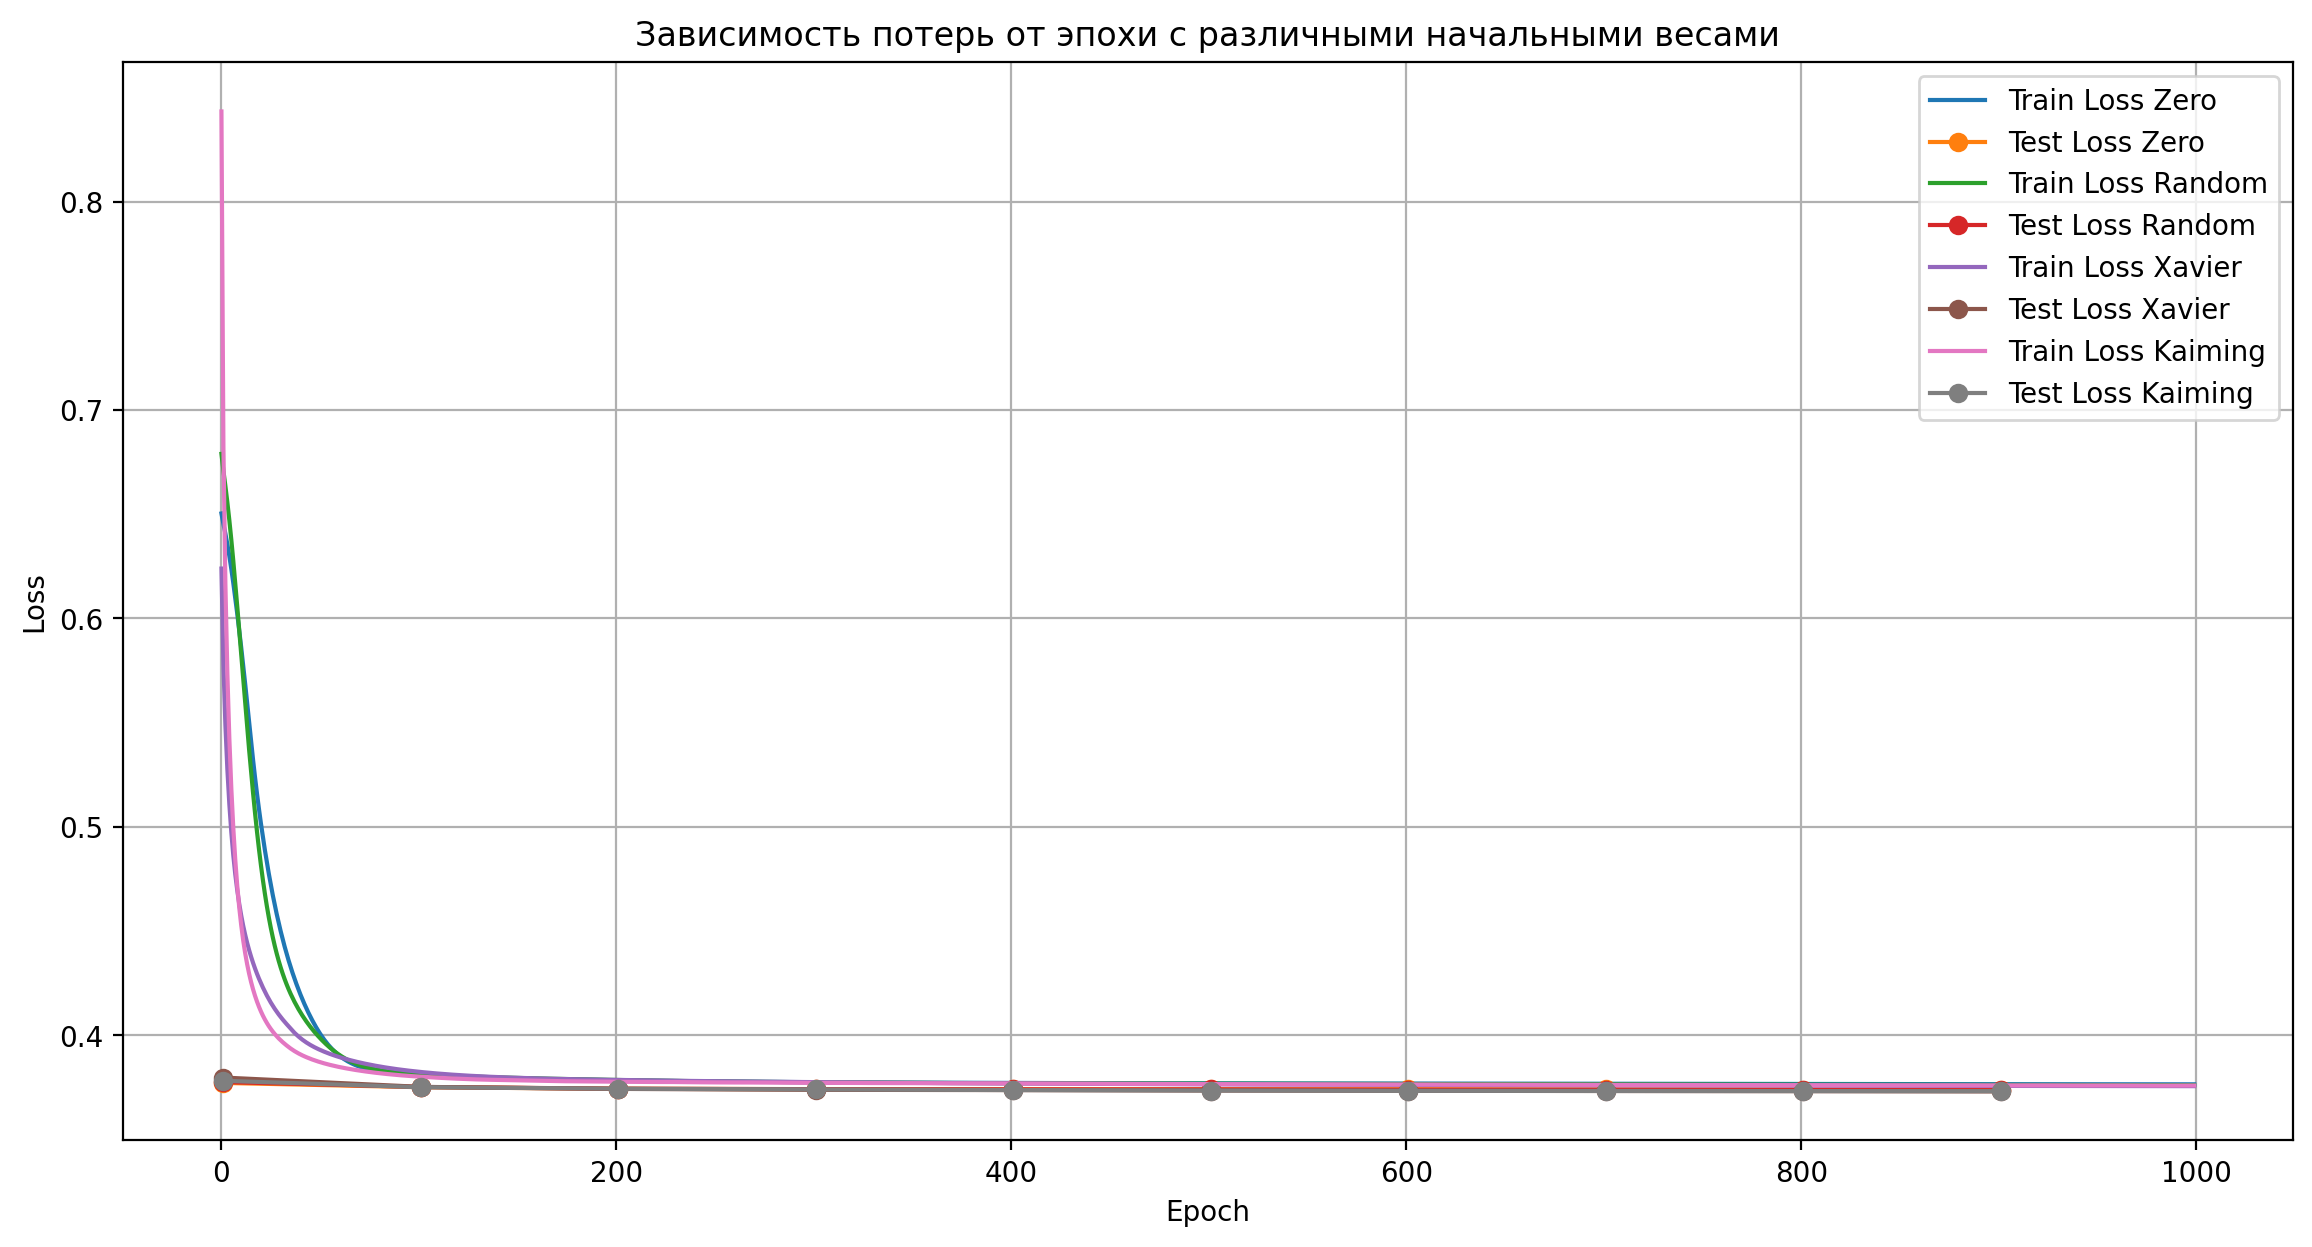

  Weight Initialization  Потери валидации
0                  Zero          0.373997
1                Random          0.373731
2                Xavier          0.373117
3               Kaiming          0.373259


In [49]:
weight_initializers = {
    'Zero': init_weights_zero,
    'Random': init_weights_random,
    'Xavier': init_weights_xavier,
    'Kaiming': init_weights_Kaiming,
}

activation_fn = nn.LeakyReLU()
hidden_layers = [20, 20]

results = {}

for name, weight_init in weight_initializers.items():
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, weight_init)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(epochs_plot, data['test_loss'], label=f'Test Loss {name}', marker='o')

plt.title('Зависимость потерь от эпохи с различными начальными весами')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Weight Initialization': [k for k in results.keys()],
    'Потери валидации': [v['final_test_loss'] for v in results.values()]
})
print(results_df)